In [9]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings("ignore")

path_to_git = "/Users/harshparikh/Documents/GitHub/iic_causal_inference/"

iic_burden = pd.read_pickle(
    path_to_git + "aim1/data_to_fit_CNNIIC_iic_burden_smooth_W300.pickle"
)

iic_burden.keys()

sns.set(font_scale=4, style="whitegrid")


def plot_unit(E, D, Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig, axs = plt.subplots(
        nrows=1 + D.shape[1],
        ncols=1,
        sharex=True,
        figsize=(15, 6 + 1.25 * n_drugs),
        gridspec_kw={"height_ratios": [4] + [1 for i in range(D.shape[1])]},
    )
    axs[0].plot(E, c="black", label="Observed")
    axs[0].set_title("IIC Burden")
    for i in range(1, 1 + n_drugs):
        y = D[:, i - 1]
        axs[i].imshow(y[np.newaxis, :], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i - 1])


def setup_data(iic_burden, frame=10):
    df = pd.DataFrame(
        iic_burden["C"], columns=iic_burden["Cname"], index=iic_burden["sids"]
    )
    df["mRS"] = iic_burden["Y"]
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in range(n):
        try:
            E = iic_burden["Pobs"][i][:frame]
            Ename = ["iic_%d" % (j) for j in range(frame)]
            D = iic_burden["D"][i][:frame, :]
            time_of_intervention = np.argmax(D.sum(axis=1) > 0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame - 1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array(
                [
                    ["%s_%d" % (drug, j) for drug in iic_burden["Dname"]]
                    for j in range(frame)
                ]
            ).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden["Dname"][np.argmax(D[time_of_intervention, :])]
            Dname_summary = iic_burden["Dname"]
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame(
                [
                    [time_of_intervention]
                    + [First_D]
                    + list(E)
                    + [E_summary_pre, E_summary_post]
                    + list(D_flat)
                    + list(D_summary)
                ],
                index=[df.index[i]],
                columns=["time_of_intervention"]
                + ["drug_administered"]
                + Ename
                + ["avg_iic_pre", "avg_iic_post"]
                + list(Dname_flat)
                + list(Dname_summary),
            )
            #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df


def setup_coarsen_data(iic_burden, window=36, summarize="max", **kwargs):
    df = pd.DataFrame(
        iic_burden["C"], columns=iic_burden["Cname"], index=iic_burden["sids"]
    )
    df["mRS"] = iic_burden["Y"]
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in range(n):
        t = len(iic_burden["Pobs"][i])
        if t > window:
            if summarize == "max":
                E = np.max(
                    [
                        np.nanmean(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )
            if summarize == "proportion":
                threshold = kwargs.get("threshold", 0.5)
                E = np.nanmean(
                    np.array(
                        [
                            np.nanmean(iic_burden["Pobs"][i][j : j + window])
                            for j in range(t - window)
                        ]
                    )
                    > threshold
                )
            if summarize == "mean":
                E = np.mean(
                    [
                        np.nanmean(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )
            if summarize == "median":
                E = np.mean(
                    [
                        np.nanmedian(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )

        else:
            E = np.nanmean(iic_burden["Pobs"][i])
        E_col.append(E)
        D = np.nanmean(iic_burden["D"][i], axis=0)
        D_col.append(D)
    df["E"] = E_col
    df_D = pd.DataFrame(D_col, columns=iic_burden["Dname"], index=df.index)
    df = df.join(df_D, how="inner")
    return df


df_pkpd = pd.read_csv("PD_Parameters_result.csv", index_col=0)
df_pkpd = df_pkpd.fillna(df_pkpd.mean())

print(df_pkpd.shape[0])

df_coarsen = setup_coarsen_data(iic_burden, window=6, summarize="max")

df_coarsen_mean = setup_coarsen_data(iic_burden, window=6, summarize="mean")
df_coarsen_max = setup_coarsen_data(iic_burden, window=6, summarize="max")
df_coarsen_median = setup_coarsen_data(iic_burden, window=6, summarize="median")

print(df_coarsen.shape[0])
# df_pkpd = pd.read_csv('../aim1/step6_simulator/results_iic_burden_smooth/params_mean_CNNIIC_iic_burden_smooth_cauchy_expit_lognormal_drugoutside_ARMA2,6_iter1000.csv',
#                      index_col=0, header=0)
# df_pkpd = df_pkpd[['alpha0', 'alpha[1]','alpha[2]', 'b[lacosamide]', 'b[levetiracetam]',
#                    'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]','b[valproate]']].fillna(0)
df_coarsen_1 = df_coarsen[
    iic_burden["Cname"]
    + [
        "mRS",
        "E",
        "lacosamide",
        "levetiracetam",
        "midazolam",
        "pentobarbital",
        "phenobarbital",
        "propofol",
        "valproate",
    ]
].dropna()

print(df_coarsen_1.shape[0])

df_coarsen_1 = df_coarsen_1.join(df_pkpd, how="inner")
print(df_coarsen_1.shape[0])

continuous = [
    "Age",
    "iGCS-Total",
    "iGCS = T?",
    "Worst GCS in 1st 24h",
    "Worst GCS intub",
    "APACHE II 1st 24h",
    "SBP highest (1st 24h)",
    "SBP lowest (1st 24h)",
    "DBP highest (1st 24h)",
    "DBP lowest (1st 24h)",
    "HR highest (1std 24h)",
    "HR lowest (1st 24h)",
    "premorbid MRS",
]
discrete = set(iic_burden["Cname"]).difference(continuous)

df_coarsen_1["Y"] = (df_coarsen_1["mRS"] > 3).astype(float)

n_thresholds = 5
thresholds = [-0.000001, 0.25, 0.5, 0.75, 1]  # list(np.linspace(0,1,num=n_thresholds))
gain = 0.25
iic_level = df_coarsen_1["E"] > 2
for threshold in thresholds:
    iic_level = iic_level + gain * (df_coarsen_1["E"] > threshold).astype(int)

iic_level = iic_level - (gain / 2) * ((iic_level - (gain / 2)) > 0)
drug_level = (
    (df_coarsen_1["levetiracetam"] > 20)
    + (df_coarsen_1["propofol"] > 1)
    + (df_coarsen_1["midazolam"] > 0)
    + (df_coarsen_1["lacosamide"] > 0)
    + (df_coarsen_1["pentobarbital"] > 0)
    + (df_coarsen_1["phenobarbital"] > 0)
    + (df_coarsen_1["valproate"] > 0)
).astype(int)

df_coarsen_1["iic"] = np.round(iic_level, 2).astype(str)
df_coarsen_1["drug"] = drug_level
df_coarsen_1["T"] = (
    "("
    + df_coarsen_1["iic"].astype(str)
    + ", "
    + df_coarsen_1["drug"].astype(str)
    + ")"
)
print(df_coarsen_1.shape[0])

df_race = pd.read_csv("covariates-full.csv", index_col=0)[["Race"]]
df_race = df_race.loc[list(df_coarsen_1.index)]
df_race = pd.get_dummies(df_race)[
    ["Race_Asian", "Race_Black or African American", "Race_White or Caucasian"]
]

df_coarsen_1 = df_coarsen_1.drop(
    columns=["Race_White or Caucasian", "Race_Asian", "Race_Black or African American"],
    errors="ignore",
).join(df_race, how="inner")
print(df_coarsen_1.shape[0])

# df_coarsen_1.to_csv('max_df_coarsen.csv')

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
1310
1323
997
995
995
995


# Descriptive Analysis

In [19]:
pd.DataFrame(
    np.corrcoef(
        [
            df_coarsen_max["E"].dropna(),
            df_coarsen_mean["E"].dropna(),
            df_coarsen_median["E"].dropna(),
        ]
    ),
    columns=["Emax", "Emean", "Emedian"],
    index=["Emax", "Emean", "Emedian"],
)

,Emax,Emean,Emedian
Emax,1.000000,0.716358,0.701151
Emean,0.716358,1.000000,0.998889
Emedian,0.701151,0.998889,1.000000


In [25]:
df_coarsen_1["iic"] = df_coarsen_1["iic"].replace(
    {
        "0.12": "[0.0,0.25)",
        "0.38": "[0.25,0.50)",
        "0.62": "[0.50,0.75)",
        "0.88": "[0.75,1.00]",
    }
)

### (df_coarsen_1.groupby(by=["iic", "drug"]).count()[["Race_Asian"]]).round(2)

In [40]:
(
    df_coarsen_1.groupby(by=["iic", "drug"]).mean()[
        ["Race_Asian", "Race_Black or African American", "Race_White or Caucasian"]
    ]
    * 100
).round(2)

Race_Asian  Race_Black or African American  \
iic         drug                                               
[0.0,0.25)  0           3.53                            7.06   
            1           1.80                            8.11   
[0.25,0.50) 0           2.50                            2.50   
            1           4.44                            3.33   
[0.50,0.75) 0           3.03                            6.06   
            1           1.35                           12.16   
[0.75,1.00] 0           4.03                            6.45   
            1           4.28                            7.65   

                  Race_White or Caucasian  
iic         drug                           
[0.0,0.25)  0                       77.65  
            1                       74.77  
[0.25,0.50) 0                       80.00  
            1                       76.67  
[0.50,0.75) 0                       78.79  
            1                       68.92  
[0.75,1.00] 0                       79.03  
            1                       74.31

<AxesSubplot:>

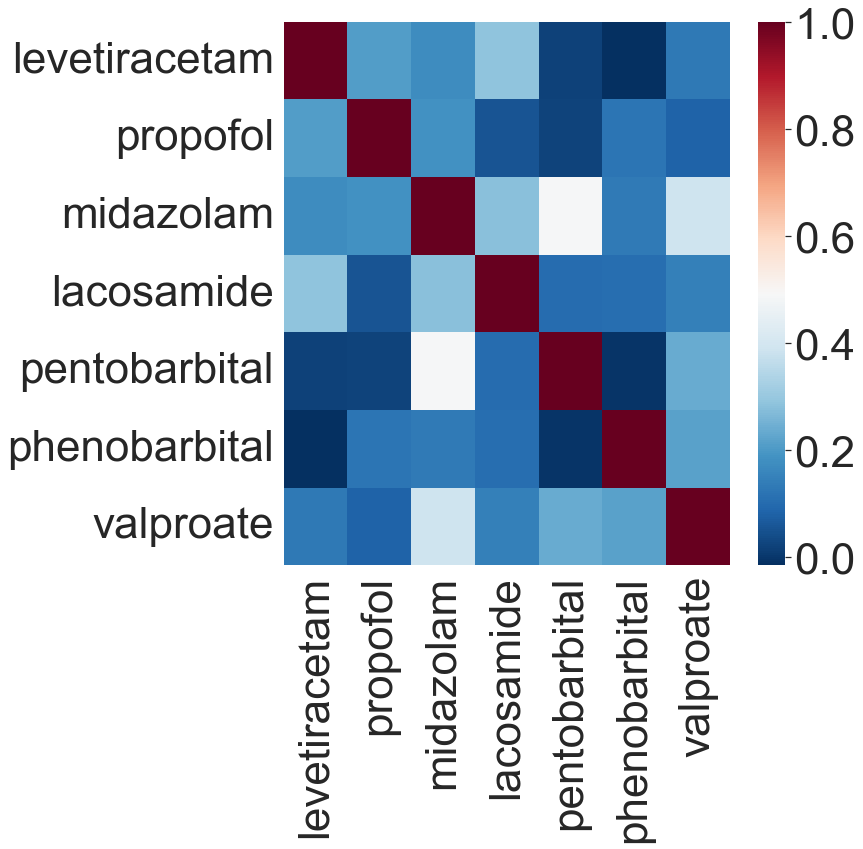

In [58]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(
    df_coarsen_1[
        [
            "levetiracetam",
            "propofol",
            "midazolam",
            "lacosamide",
            "pentobarbital",
            "phenobarbital",
            "valproate",
        ]
    ].corr(),
    cmap="RdBu_r",
)

In [67]:
drugs_df = df_coarsen_1[
    [
        "levetiracetam",
        "propofol",
        "midazolam",
        "lacosamide",
        "pentobarbital",
        "phenobarbital",
        "valproate",
    ]
]
drugs_df["levetiracetam"] = (drugs_df["levetiracetam"] > 20).astype(int)
drugs_df["propofol"] = (drugs_df["propofol"] > 1).astype(int)
drugs_df = (drugs_df > 0).astype(int)
(pd.DataFrame(drugs_df.sum(), columns=["Num. of Patients"]))

,Num. of Patients
levetiracetam,539
propofol,437
midazolam,99
lacosamide,76
pentobarbital,5
phenobarbital,24
valproate,41


In [74]:
drugs_df_2 = np.matmul(drugs_df.T, drugs_df)
drugs_df_2.columns = [
    "levetiracetam",
    "propofol",
    "midazolam",
    "lacosamide",
    "pentobarbital",
    "phenobarbital",
    "valproate",
]
drugs_df_2

,levetiracetam,propofol,midazolam,lacosamide,pentobarbital,phenobarbital,valproate
levetiracetam,539,285,73,64,3,13,28
propofol,285,437,80,36,4,16,19
midazolam,73,80,99,20,4,6,13
lacosamide,64,36,20,76,2,4,10
pentobarbital,3,4,4,2,5,0,1
phenobarbital,13,16,6,4,0,24,1
valproate,28,19,13,10,1,1,41


In [8]:
pd.DataFrame(df_pkpd[[col for col in df_pkpd.columns if "50" in col]].median().round(2))

,0
lacosamide_50,0.57
levetiracetam_50,51.00
midazolam_50,12.51
pentobarbital_50,29.74
phenobarbital_50,31.26
propofol_50,28.55
valproate_50,50.07


# Effect of IIC Burden on Outcome

## Controlling for age

In [28]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[['Age','Y','T']]
discrete = []
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

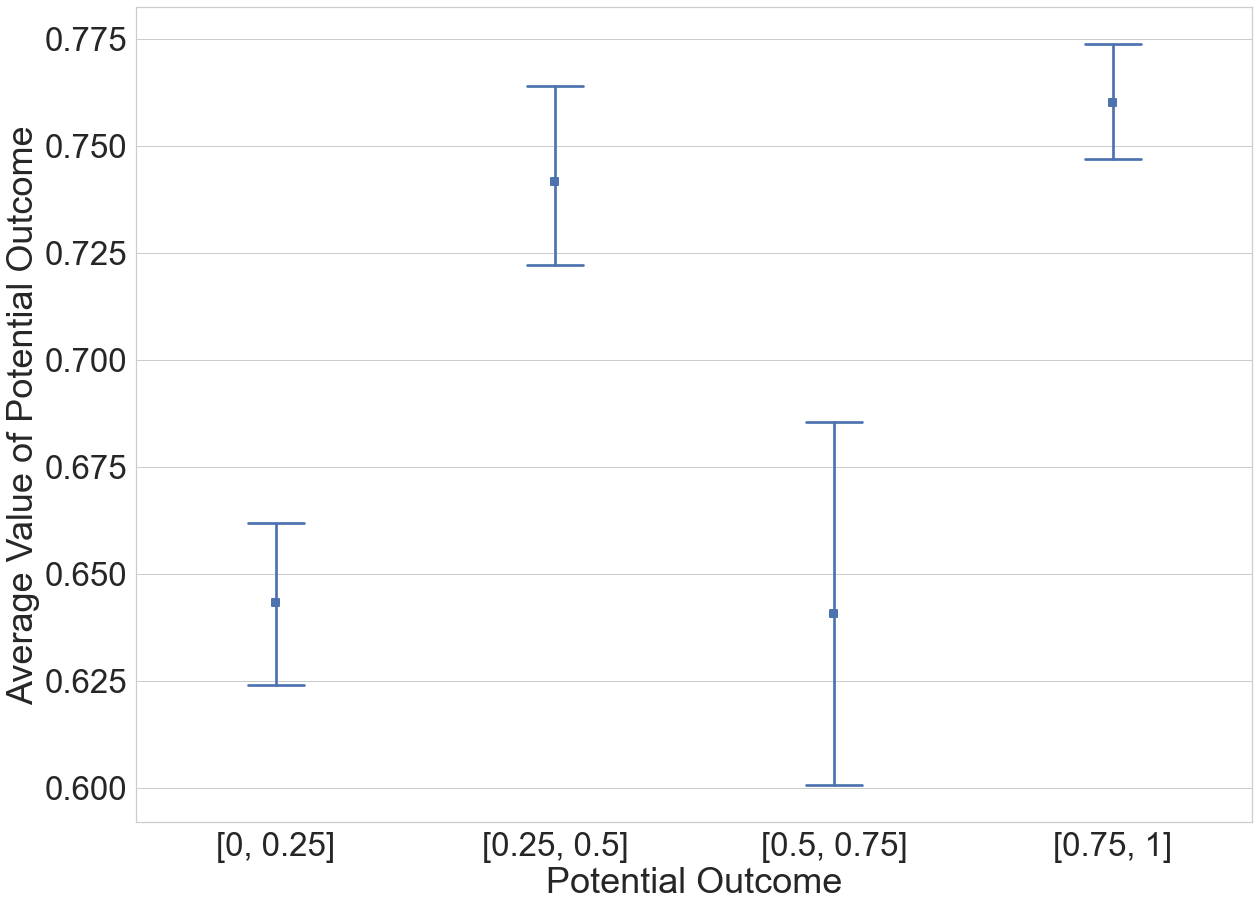

In [29]:
out_age = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_age.to_csv('new_max_age.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
apo_0_age = out_age[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
apo_1_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
diam_0_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
diam_1_age = out_age[columns]

apo_tight_0_age = pd.DataFrame(apo_0_age.values*(diam_0_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_0_age.index,columns=apo_0_age.columns)
apo_tight_0_age.mean(axis=0)

apo_tight_1_age = pd.DataFrame(apo_1_age.values*(diam_1_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_1_age.index,columns=apo_1_age.columns)
apo_tight_1_age.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_age.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_max_age.png')

In [30]:
apo_tight_0_age.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_max_age.csv')

## Controlling for All Preadmission Covariates

In [88]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']+['Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))

m_c = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

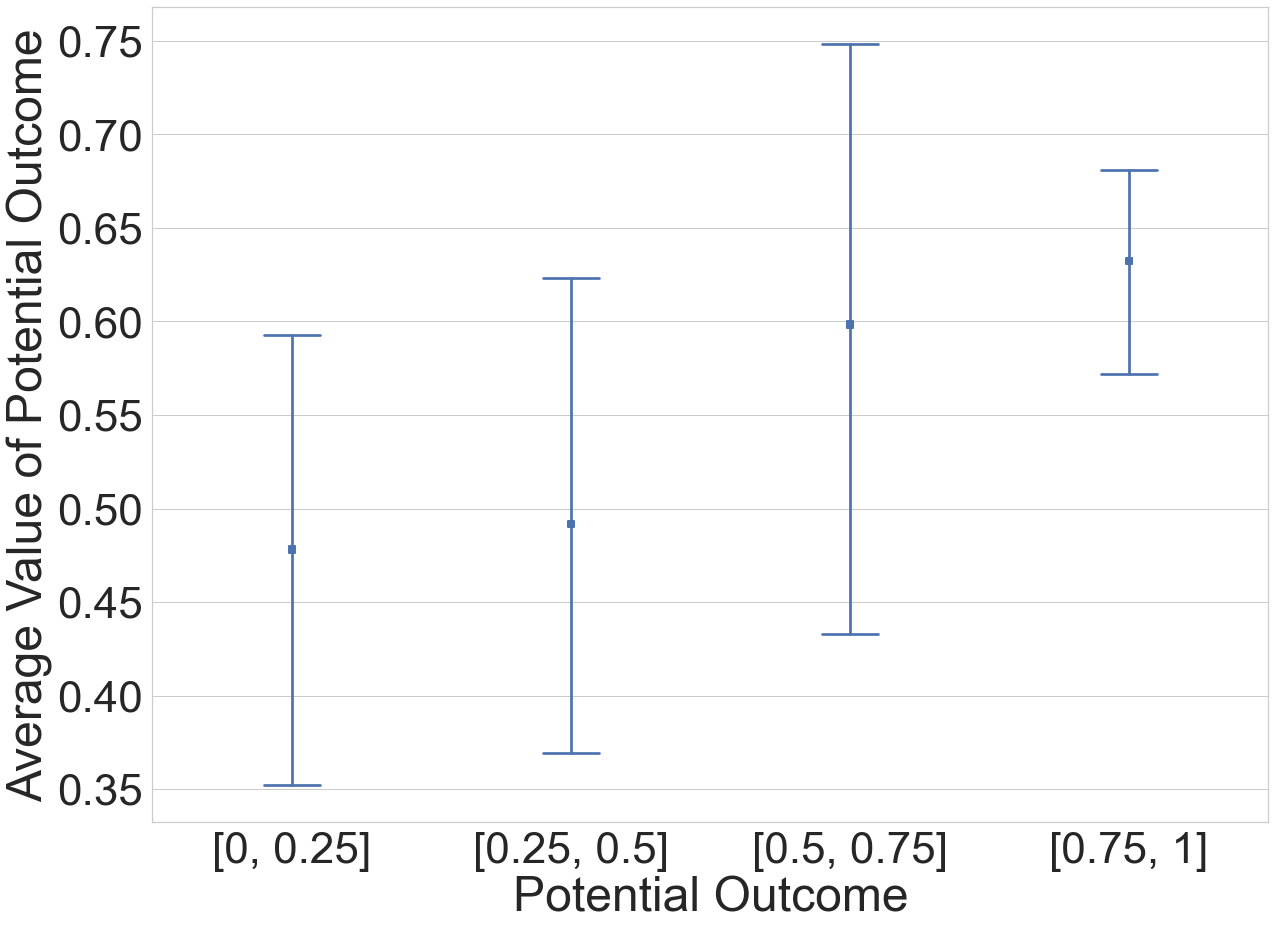

In [89]:
out_c = m_c.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_c.to_csv('new_max_c.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c = out_c[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(apo_0_c.values*(diam_0_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_0_c.index,columns=apo_0_c.columns)
apo_tight_0_c.mean(axis=0)

apo_tight_1_c = pd.DataFrame(apo_1_c.values*(diam_1_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_1_c.index,columns=apo_0_c.columns)
apo_tight_1_c.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_max_c.png')

In [90]:
apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_max_c.csv')

# Controlling for all pre-admission covariates and PKPD parameters

In [67]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']+list(df_pkpd.columns)+['Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=3,
                k_est=5,
                discrete = discrete,
                C=0.01)

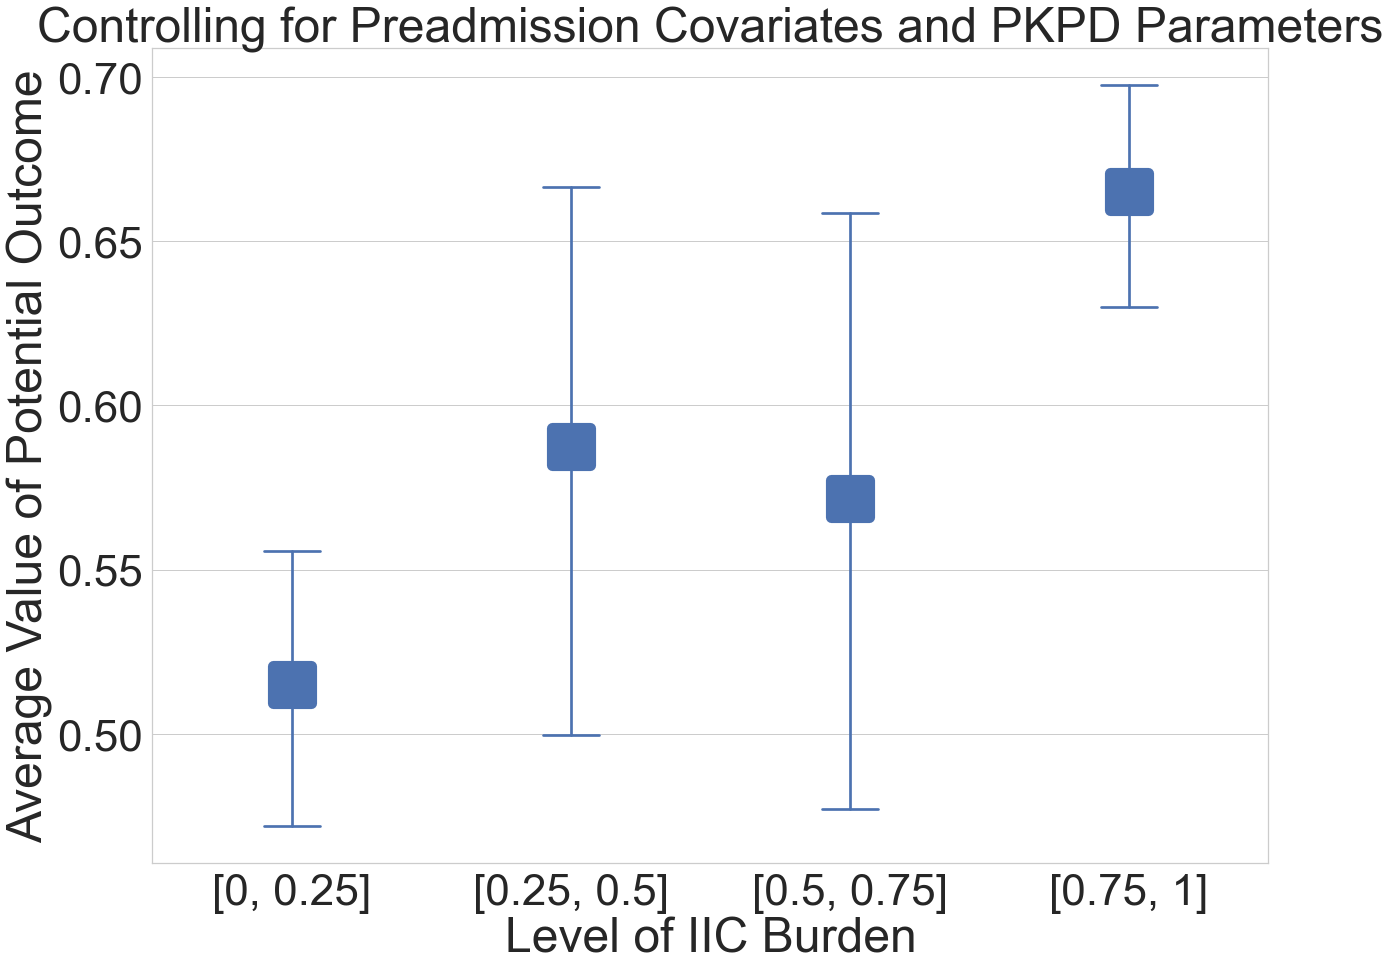

In [68]:
out = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out.to_csv('new_max_c_pkpd.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c_pkpd = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<2000).astype(int).replace(0, np.nan).values,
                         index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_0_c_pkpd.mean(axis=0)

apo_tight_1_c_pkpd = pd.DataFrame(apo_1_c_pkpd.values*(diam_1_c_pkpd<2000).astype(int).replace(0, np.nan).values,
                         index=apo_1_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_1_c_pkpd.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], scale = 5.5)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
plt.title('Controlling for Preadmission Covariates and PKPD Parameters')
fig.savefig('new_max_c_pkpd.png')

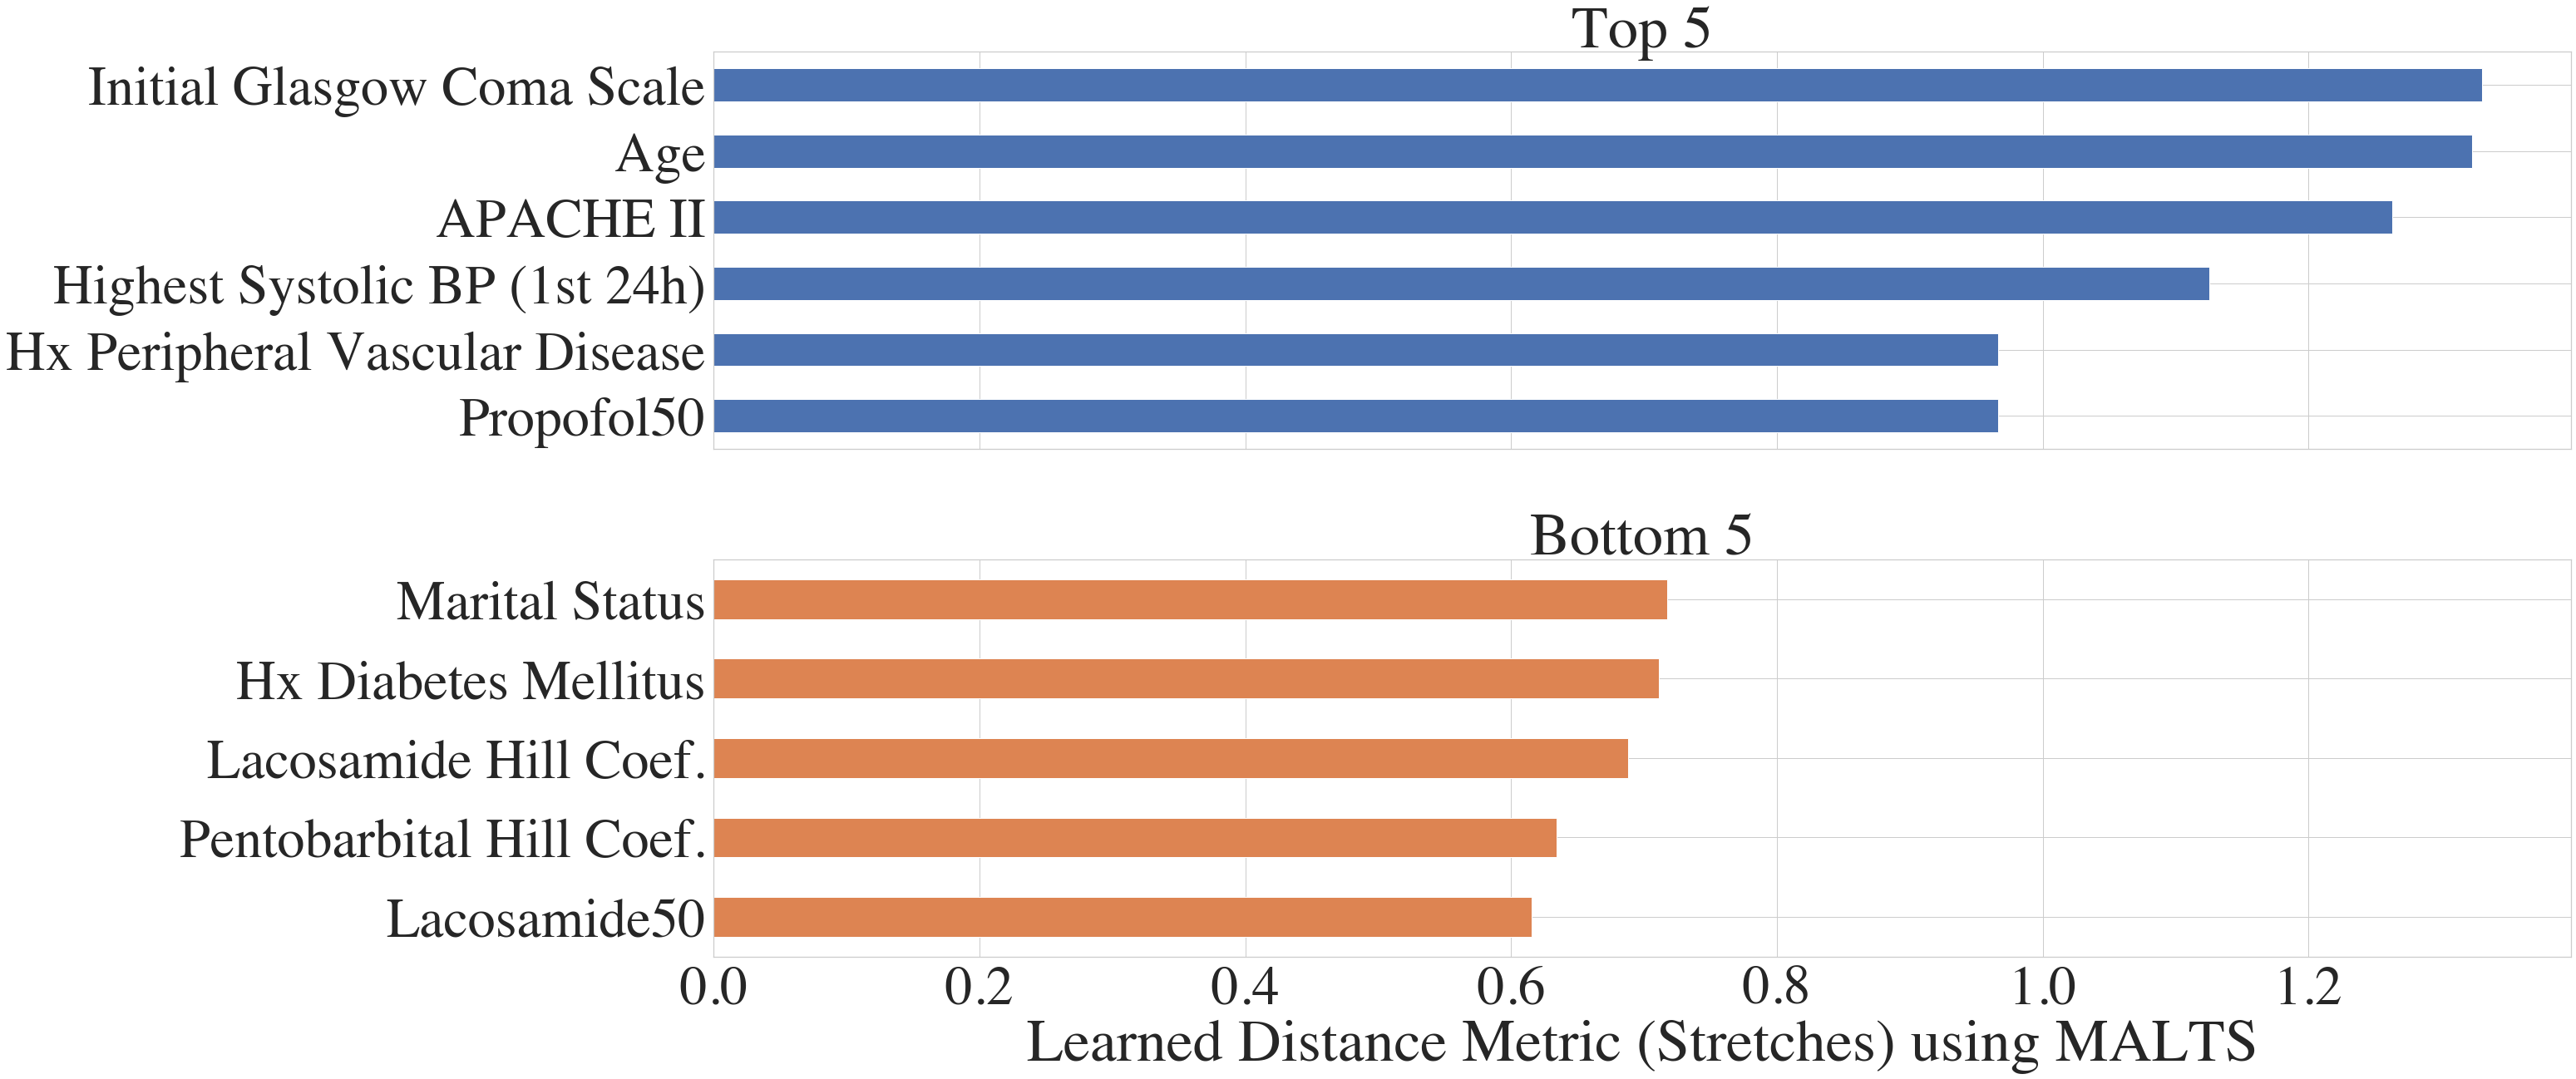

In [22]:
sns.set(font_scale=6,style='whitegrid')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)
fig,ax = plt.subplots(figsize=(45,20),nrows=2,sharex=True)
# pd.concat(m.M_opt_list).to_csv('M_opt_max.csv')
M_opt = pd.read_csv('M_opt_max.csv',index_col=0)
columns_order = list(M_opt.mean(axis=0).sort_values(ascending=False).index)
columns_to_include_top = ['iGCS-Total','Age','APACHE II 1st 24h','SBP highest (1st 24h)','Hx PVD','propofol_50'][::-1]
columns_to_include_bottom = ['Marrital','Hx DM','lacosamide_Hill','pentobarbital_Hill','lacosamide_50'][::-1]
# pd.concat(m.M_opt_list)[columns_order].plot(kind='box',ax=ax,rot=90,showmeans=True)
# M_opt[columns_to_include].std(axis=0)/2
# plt.ylim(-0.001,1.0)
M_opt[columns_to_include_top].mean(axis=0).rename(index={'propofol_50': 'Propofol50',
                                                         'Hx PVD':'Hx Peripheral Vascular Disease',
                                                         'SBP highest (1st 24h)':'Highest Systolic BP (1st 24h)',
                                                         'APACHE II 1st 24h':'APACHE II',
                                                         'iGCS-Total':'Initial Glasgow Coma Scale'}).plot(kind='barh',ax=ax[0],color='C0')
ax[0].set_title('Top 5')
# ax[0].set_xticks([1,2,3,4,5],['Initial Glasgow Comma Score','Age','APACHE II Score','Systolic Blood Pressure','Peripheral vascular disease','Propofol50'])
M_opt[columns_to_include_bottom].mean(axis=0).rename(index={'Marrital': 'Marital Status',
                                                         'Hx DM':'Hx Diabetes Mellitus',
                                                         'lacosamide_Hill':'Lacosamide Hill Coef.',
                                                         'pentobarbital_Hill':'Pentobarbital Hill Coef.',
                                                         'lacosamide_50':'Lacosamide50'}).plot(kind='barh',ax=ax[1],color='C1')
ax[1].set_title('Bottom 5')
plt.subplots_adjust(wspace=0.005, hspace=0.1)
plt.xlabel('Learned Distance Metric (Stretches) using MALTS')
plt.tight_layout()
plt.savefig('max_stretchplot.png')


In [15]:
M_opt[columns_to_include_top].mean(axis=0).rename(index={'propofol_50': 'Propofol 50',
                                                         'Hx PVD':'Hx Peripheral Vascular Disease',
                                                         'SBP highest (1st 24h)':'max Systolic BP (1st 24h)',
                                                         'APACHE II 1st 24h':'APACHE II',
                                                         'iGCS-Total':'Glasgow Coma Score'})

Propofol 50                       0.966192
Hx Peripheral Vascular Disease    0.966262
max Systolic BP (1st 24h)         1.125256
APACHE II                         1.262853
Age                               1.323103
Glasgow Coma Score                1.330726
dtype: float64

In [10]:
pd.concat(m.M_opt_list).mean(axis=0).to_csv('MALTS_distmat.csv')

In [101]:
apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_c_pkpd.csv')

In [102]:
out_age= pd.read_csv('new_max_age.csv',index_col=0)
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
apo_0_age = out_age[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
apo_1_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
diam_0_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
diam_1_age = out_age[columns]

apo_tight_0_age = pd.DataFrame(apo_0_age.values*(diam_0_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_0_age.index,columns=apo_0_age.columns)



out_c = pd.read_csv('new_max_c.csv',index_col=0)
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c = out_c[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(apo_0_c.values*(diam_0_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_0_c.index,columns=apo_0_c.columns)



out = pd.read_csv('new_max_c_pkpd.csv',index_col=0)
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c_pkpd = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<2000).astype(int).replace(0, np.nan).values,
                         index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)

In [3]:
apo_tight_0_age = pd.read_csv('average_te_max_age.csv',index_col=0)
apo_tight_0_c = pd.read_csv('average_te_max_c.csv',index_col=0)
apo_tight_0_c_pkpd = pd.read_csv('average_te_c_pkpd.csv',index_col=0)

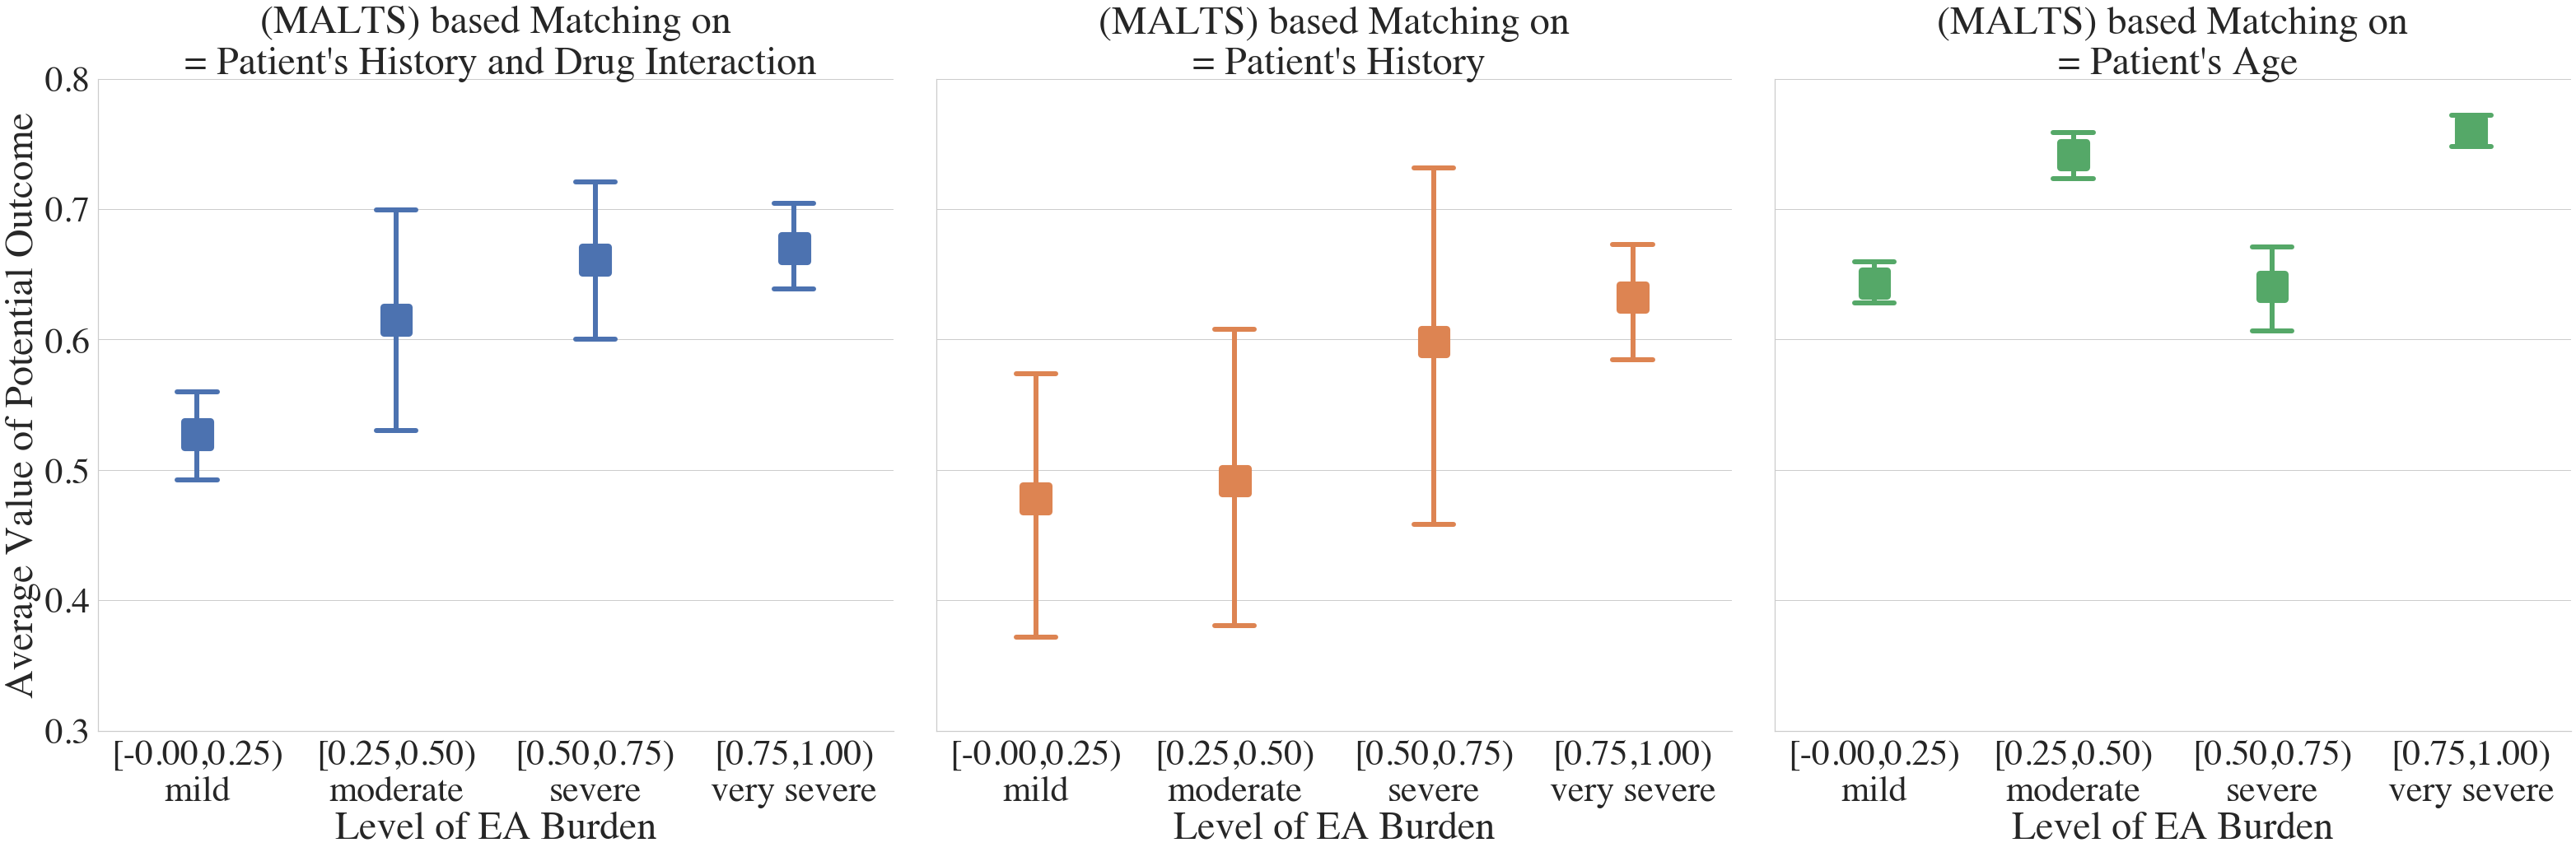

In [9]:
sns.set(font_scale=4,style='whitegrid')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)

# fig,ax = plt.subplots(figsize=(20,15))
control = ['Patient\'s History and Drug Interaction','Patient\'s History','Patient\'s Age']
df_apo = [apo_tight_0_c_pkpd,apo_tight_0_c,apo_tight_0_age]
df_plot = pd.DataFrame()
for i in range(len(df_apo)):
    df_plot_ = df_apo[i]
    df_plot_['(MALTS) based Matching on\n'] = [control[i] for k in range(df_plot_.shape[0])]
    df_plot = df_plot.append(df_plot_)

g = sns.FacetGrid(df_plot, col="(MALTS) based Matching on\n",hue='(MALTS) based Matching on\n',height=15,sharex=True,sharey=True)
g.map(sns.pointplot,
             'index','Average Potential Outcome',join=False,
             capsize=.2,markers=['s','o','v'],dodge=0.25,scale = 4.5,errwidth=6,ci=90)
# sns.lineplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
# plt.legend(['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age'],title="Controlling for")
# plt.axhline(0.528,c='black',ls='--',lw=5)
g.set_xlabels('Level of EA Burden')
g.set_ylabels('Average Value of Potential Outcome')
plt.ylim((0.3,0.8))
level_eng = ['mild','moderate','severe','very severe']
plt.xticks(np.arange(len(thresholds)-1),['[%.2f,%.2f)\n%s'%(thresholds[i-1],thresholds[i],level_eng[i-1]) for i in range(1,len(thresholds)) ] )
# plt.legend([],[], frameon=False)
plt.savefig('comp_max.png')

# Comparing to Prediction Model

In [24]:
df_logistic = df_coarsen_1[iic_burden['Cname']+['Y','iic','drug']]
df_logistic['iic'] = ((df_logistic['iic'].astype(float)*10).astype(int) - 1)//2
prognostic_model = lm.LogisticRegressionCV().fit( df_logistic[iic_burden['Cname']+['iic','drug']],  df_logistic['Y'] )

In [25]:
df_logistic_pred = df_logistic.copy(deep=True)
logit_reg_te = pd.DataFrame()
for ea in range(0,4):
    df_logistic_pred['iic'] = ea
    df_logistic_pred['drug'] = 0
    logit_reg_te_temp = pd.DataFrame()
    logit_reg_te_temp['Potential Outcome'] = [ np.mean(prognostic_model.predict_proba(df_logistic_pred.sample(frac=0.8,replace=True)[iic_burden['Cname']+['iic','drug']])[:,1]) for repeat in range(10) ]
    logit_reg_te_temp['iic'] = ea
    logit_reg_te = logit_reg_te.append(logit_reg_te_temp,ignore_index=True)

# Matched Group Analysis

In [77]:
MG = m.MG_matrix
MG_b = (MG>7).astype(int) 
MG_b = MG_b.loc[MG_b.sum(axis=1)>0]
MG_b = MG_b[list(MG_b.index)]
MG.to_csv('matched_group_matrix.csv')

In [78]:

tight_mg_idx = list(diam_0_c_pkpd.max(axis=1).sort_values().index[:6])
for idx in tight_mg_idx:
    MG_i = MG_b.loc[idx]
    df_malts_data.loc[MG_i.loc[MG_i>0].index].to_csv('mg_%s.csv'%(idx))

In [79]:
G = nx.from_pandas_adjacency(MG_b)

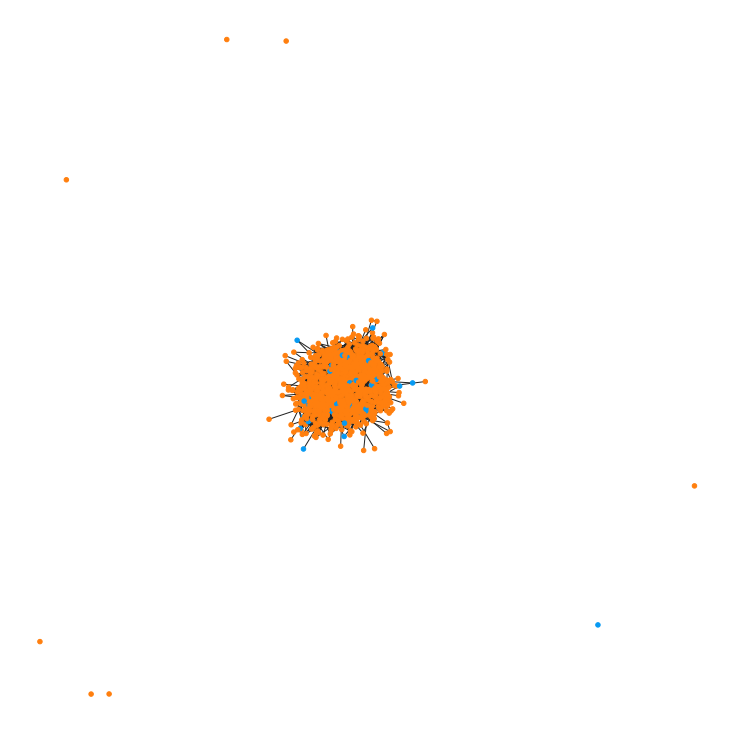

In [80]:
fig = plt.figure(figsize=(10,10))
node_color = [ '#ff7f0e' if df_malts_data.loc[i,'Hx PVD']==0 else '#069af3' for i in (MG_b.index) ]
nx.draw(G,node_size=20,node_color=node_color,edge_color='#222222')

# Heterogeneous Effect

In [18]:
out = pd.read_csv('new_max_c_pkpd.csv',index_col=0)

In [19]:
y_u = out[[i for i in out.columns if 'Y((0.88, 1))' in i]].mean(axis=1)
y_l = out[[i for i in out.columns if 'Y((0.12, 1))' in i]].mean(axis=1)
te = y_u-y_l

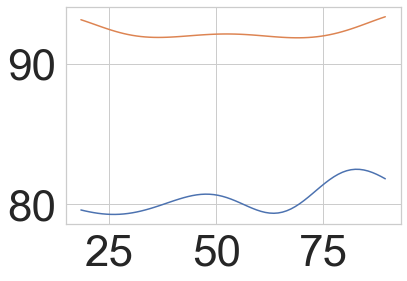

In [36]:
import sklearn.ensemble as en
m_age_l = svm.SVR().fit(df_coarsen_1[['Age']],100*y_l )
m_age_u = svm.SVR().fit(df_coarsen_1[['Age']],100*y_u )
age_range = np.arange(np.min(df_coarsen_1['Age']),np.max(df_coarsen_1['Age'])+1)
risk_age_l  = m_age_l.predict(age_range.reshape(-1,1))
risk_age_u  = m_age_u.predict(age_range.reshape(-1,1))
plt.plot(age_range,risk_age_l)
plt.plot(age_range,risk_age_u)

In [20]:
# cols = iic_burden['Cname']
hetero_te_m = {}
cols = ['NeuroDx:IschStroke', 
        'NeuroDx:HemStroke',
         'NeuroDx:Brain tumor',
         'NeuroDx:CNS infection',
         'NeuroDx:HIE/ABI',
         'NeuroDx:TME',
         'NeuroDx:Degenerative',
         'NeuroDx:Spells','Gender']
for col in cols:
    hetero_te_m[col] = tree.DecisionTreeRegressor(max_depth=4,max_leaf_nodes=8,min_samples_leaf=10).fit(df_coarsen_1[[col]],100*(y_u - y_l)/y_l)

hetero_te_m['all'] = tree.DecisionTreeRegressor(max_depth=2,max_leaf_nodes=8,min_samples_leaf=50).fit(df_coarsen_1[cols],100*(y_u - y_l)/y_l)

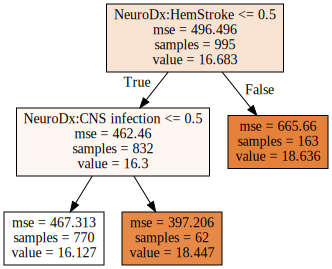

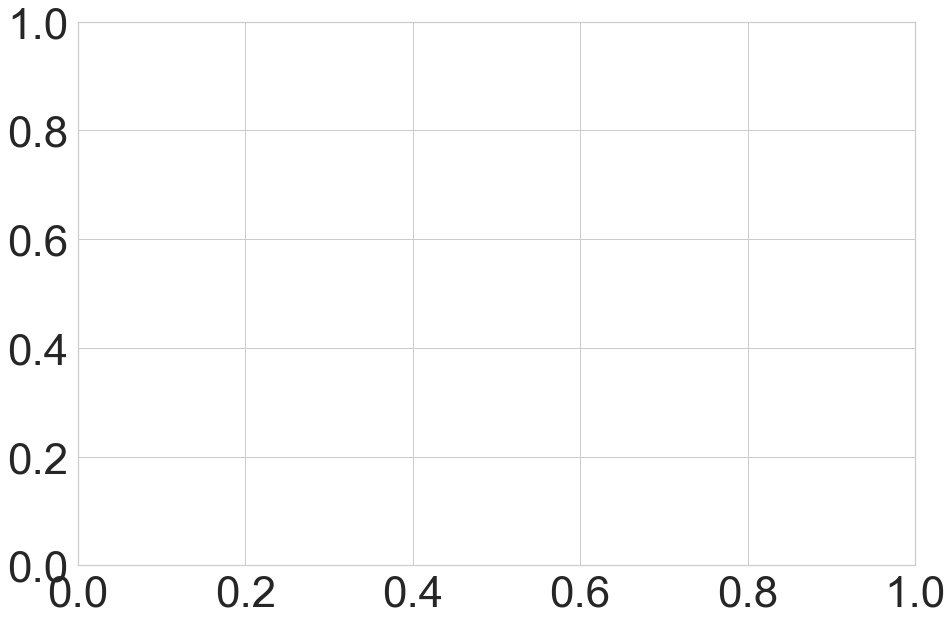

In [64]:
fig,ax = plt.subplots(figsize=(15,10))
dot_data = tree.export_graphviz(hetero_te_m['all'],feature_names=cols,filled=True)
graphviz.Source(dot_data, format="png") 
# fig.savefig('hetero_tree_%s.png'%('all'))

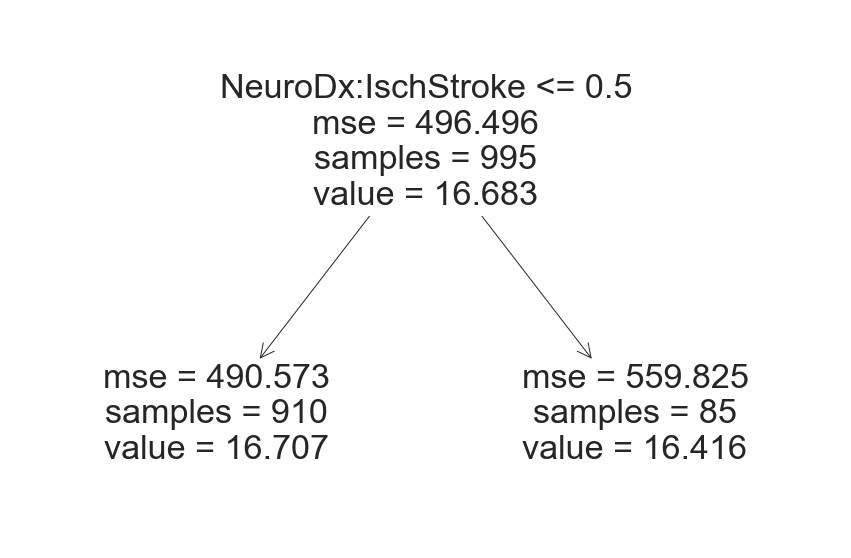

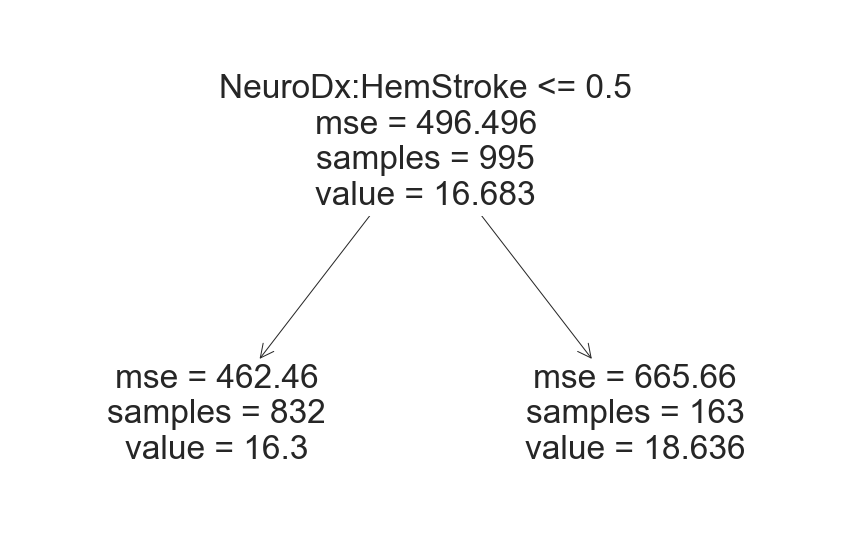

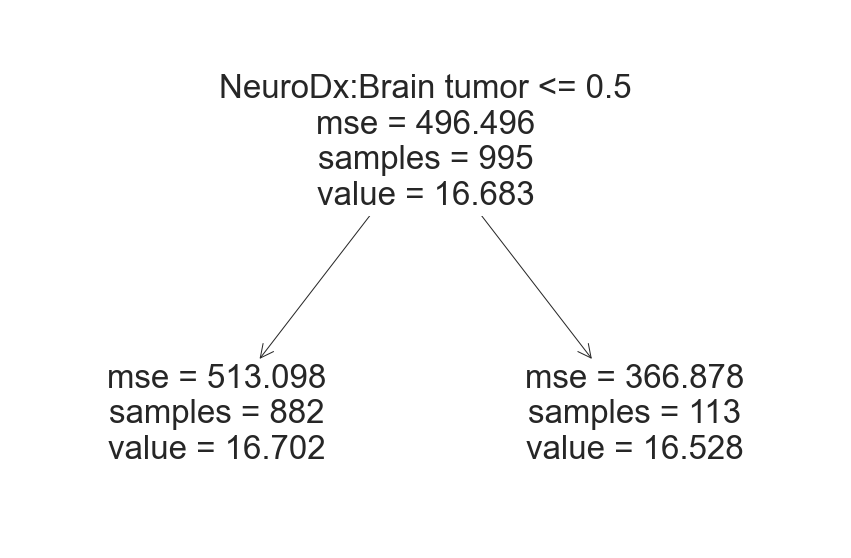

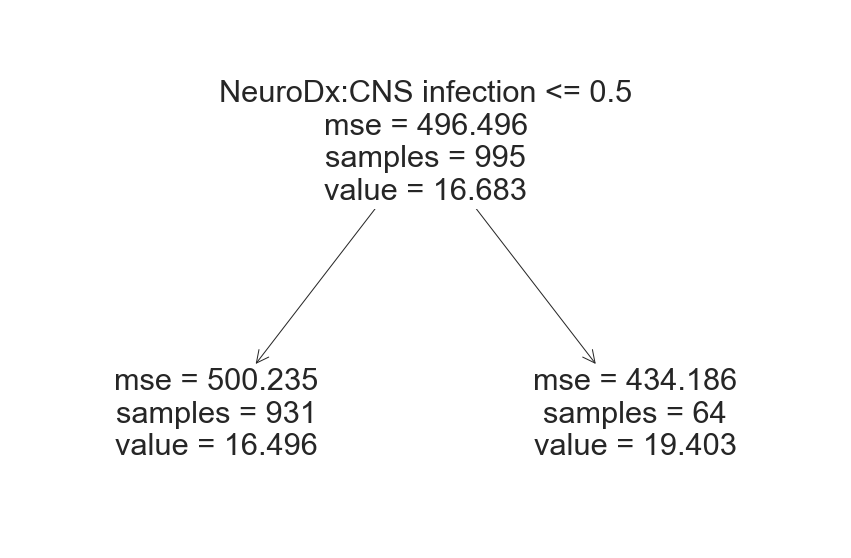

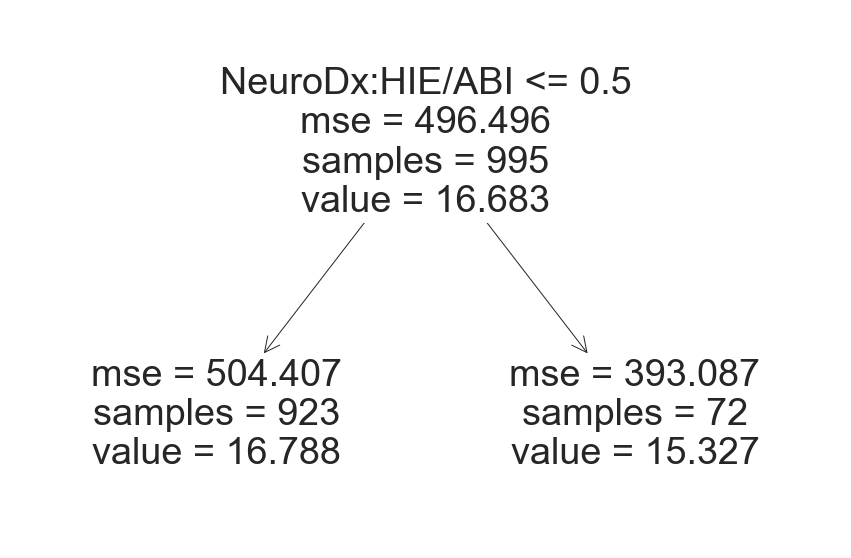

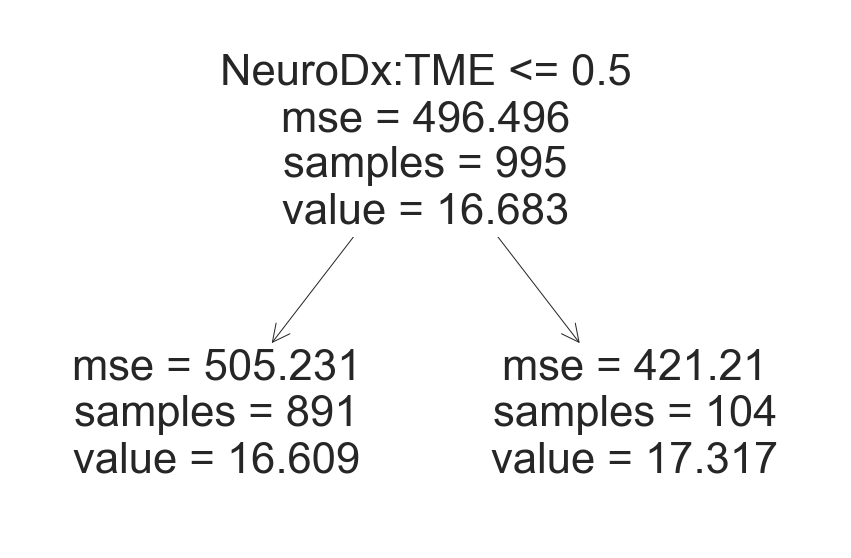

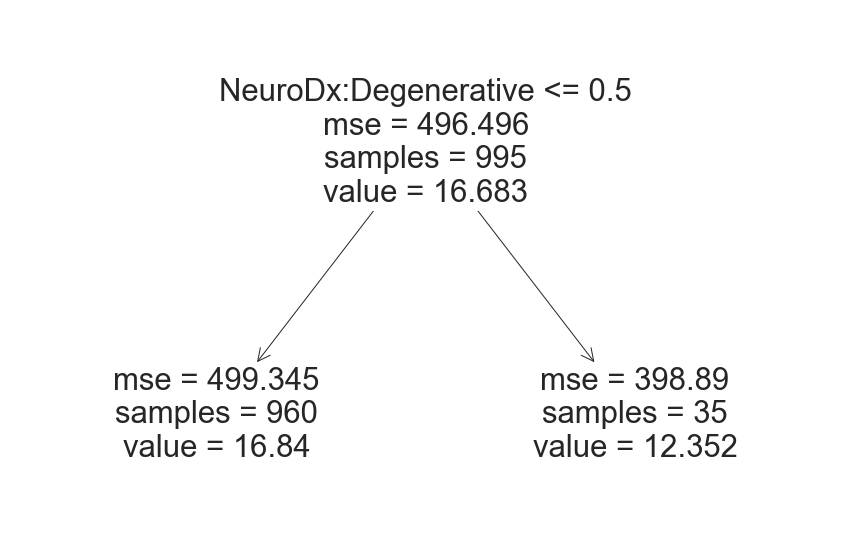

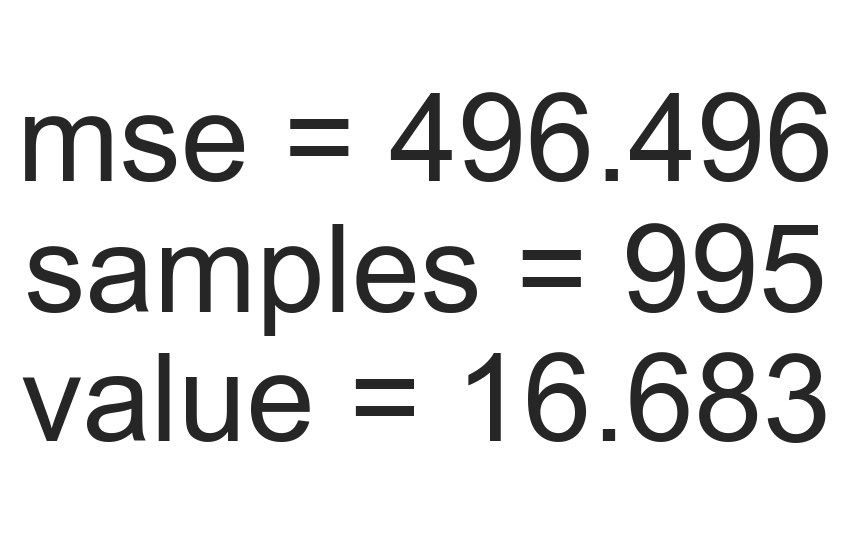

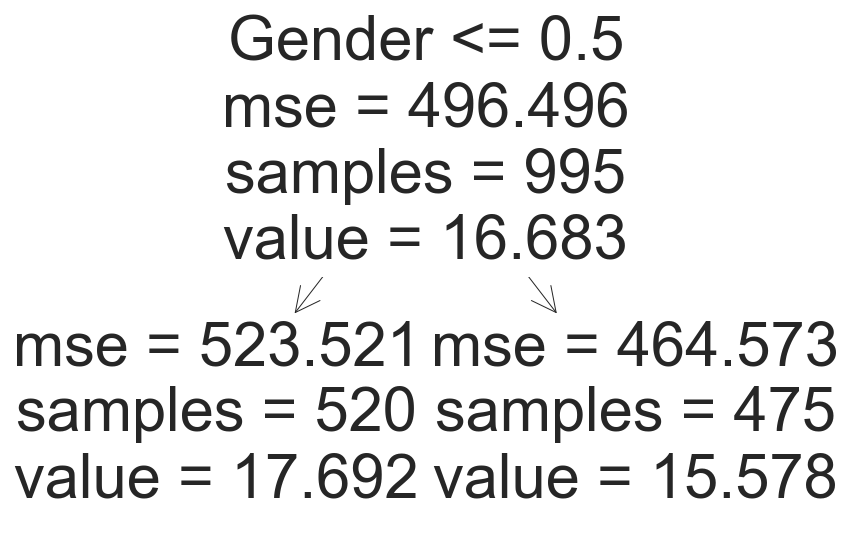

In [21]:
for col in cols:
    fig,ax = plt.subplots(figsize=(15,10))
    tree.plot_tree(hetero_te_m[col],feature_names=[col],filled=False)
    fig.savefig('hetero_tree_%s.png'%(col.replace('/','_').replace(':','_')))

In [122]:
df_apo_pkpd_c = cate_df[list(filter( lambda x: 'Y(' in x, cate_df.columns ))].T.reset_index().groupby(by='index').mean().T
df_apo_pkpd_c.to_csv('potential_outcome_pkpd_c.csv')

# Logistic Regression

In [33]:
malts_res = pd.read_csv('average_te_c_pkpd.csv',index_col=0)

In [28]:
data_lr = df_coarsen_1.drop(columns=['T','E']).astype(float)
data_lr['iic'] = ((data_lr['iic'].astype(float)*10).astype(int) - 1)//2

In [31]:
lr_model = lm.LogisticRegressionCV().fit(data_lr.drop(columns=['Y']),data_lr['Y'])

In [32]:
est_lr = pd.DataFrame()
for repeat in range(10):
    data_bootstrap = data_lr.sample(replace=True,frac=2/3)
    lr_model = lm.LogisticRegressionCV().fit(data_bootstrap.drop(columns=['Y']),data_bootstrap['Y'])
    est_lr_ = pd.DataFrame()
    for iic_b in [0,1,2,3]:
#         data_bootstrap['iic'] = iic_b
#         data_bootstrap['drug'] = 0
        est_lr_[iic_b] = [np.mean(lr_model.predict_proba(data_bootstrap.loc[(data_bootstrap['iic']==iic_b) & (data_bootstrap['drug']==0)].drop(columns=['Y']))[:,1])]
    est_lr_ = est_lr_.T
    est_lr = est_lr.append(est_lr_)


In [60]:
est_naive = pd.DataFrame()
data_naive = df_coarsen_1.drop(columns=['T','E']).astype(float)
data_naive['iic'] = ((data_naive['iic'].astype(float)*10).astype(int) - 1)//2
for repeat in range(10):
    data_bootstrap = data_naive.sample(replace=True,frac=2/3)
    est_naive_ = pd.DataFrame()
    for iic_b in [0,1,2,3]:
        data_bootstrap_iic = data_bootstrap.loc[(data_bootstrap['iic']==iic_b) & (data_bootstrap['drug']==0)]
        est_naive_[iic_b] = [np.nanmean(data_bootstrap_iic['Y'])]
    est_naive_ = est_naive_.T
    est_naive = est_naive.append(est_naive_)

In [78]:
propensity_model = lm.LogisticRegressionCV().fit(data_lr.drop(columns=['Y','iic']),data_lr['iic'])
est_pm = pd.DataFrame()
ates = []
for repeat in tqdm.tqdm(range(10)):
    data_bootstrap = data_lr.sample(replace=True,frac=2/3)
    propensity_model = lm.LogisticRegressionCV().fit(data_bootstrap.drop(columns=['Y','iic']),data_bootstrap[['iic','drug']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
))
    pscore = propensity_model.predict_proba(data_bootstrap.drop(columns=['Y','iic']))
    nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(pscore)
    distances, indices = nbrs.kneighbors(pscore)
    cates = pd.DataFrame()
    for j in range(indices.shape[0]):
        mg_prop = data_bootstrap[['Y','iic','drug']].iloc[indices[j,:]]
        mg_prop_0 = mg_prop.loc[mg_prop['drug']<0.5].drop(columns=['drug'])
        est_prop_j = mg_prop_0.groupby(by='iic').mean().T
        cates = cates.append(est_prop_j,ignore_index=True)
    ate = cates.mean(axis=0)
    ates.append(ate)
est_prop = pd.concat(ates)

100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


In [80]:
pscore

array([[3.30662484e-01, 6.33186820e-03, 2.03079257e-01, ...,
        5.84718182e-03, 4.32767254e-01, 4.20347575e-03],
       [1.19584335e-01, 3.94056235e-02, 5.20963436e-01, ...,
        1.41142383e-01, 3.45497167e-02, 1.41434963e-01],
       [1.01305802e-02, 2.78231066e-01, 4.96642716e-05, ...,
        8.30418726e-02, 1.68561782e-02, 4.44481285e-01],
       ...,
       [3.40491771e-14, 6.42118897e-02, 1.35798680e-15, ...,
        2.99700220e-02, 8.96112304e-14, 8.91698733e-01],
       [9.37453884e-15, 5.08477395e-01, 2.45285295e-12, ...,
        2.74132229e-02, 4.55782960e-13, 4.37619047e-01],
       [3.47006459e-01, 5.17044389e-03, 2.81821151e-03, ...,
        1.25486112e-03, 3.89996158e-01, 4.25735454e-03]])

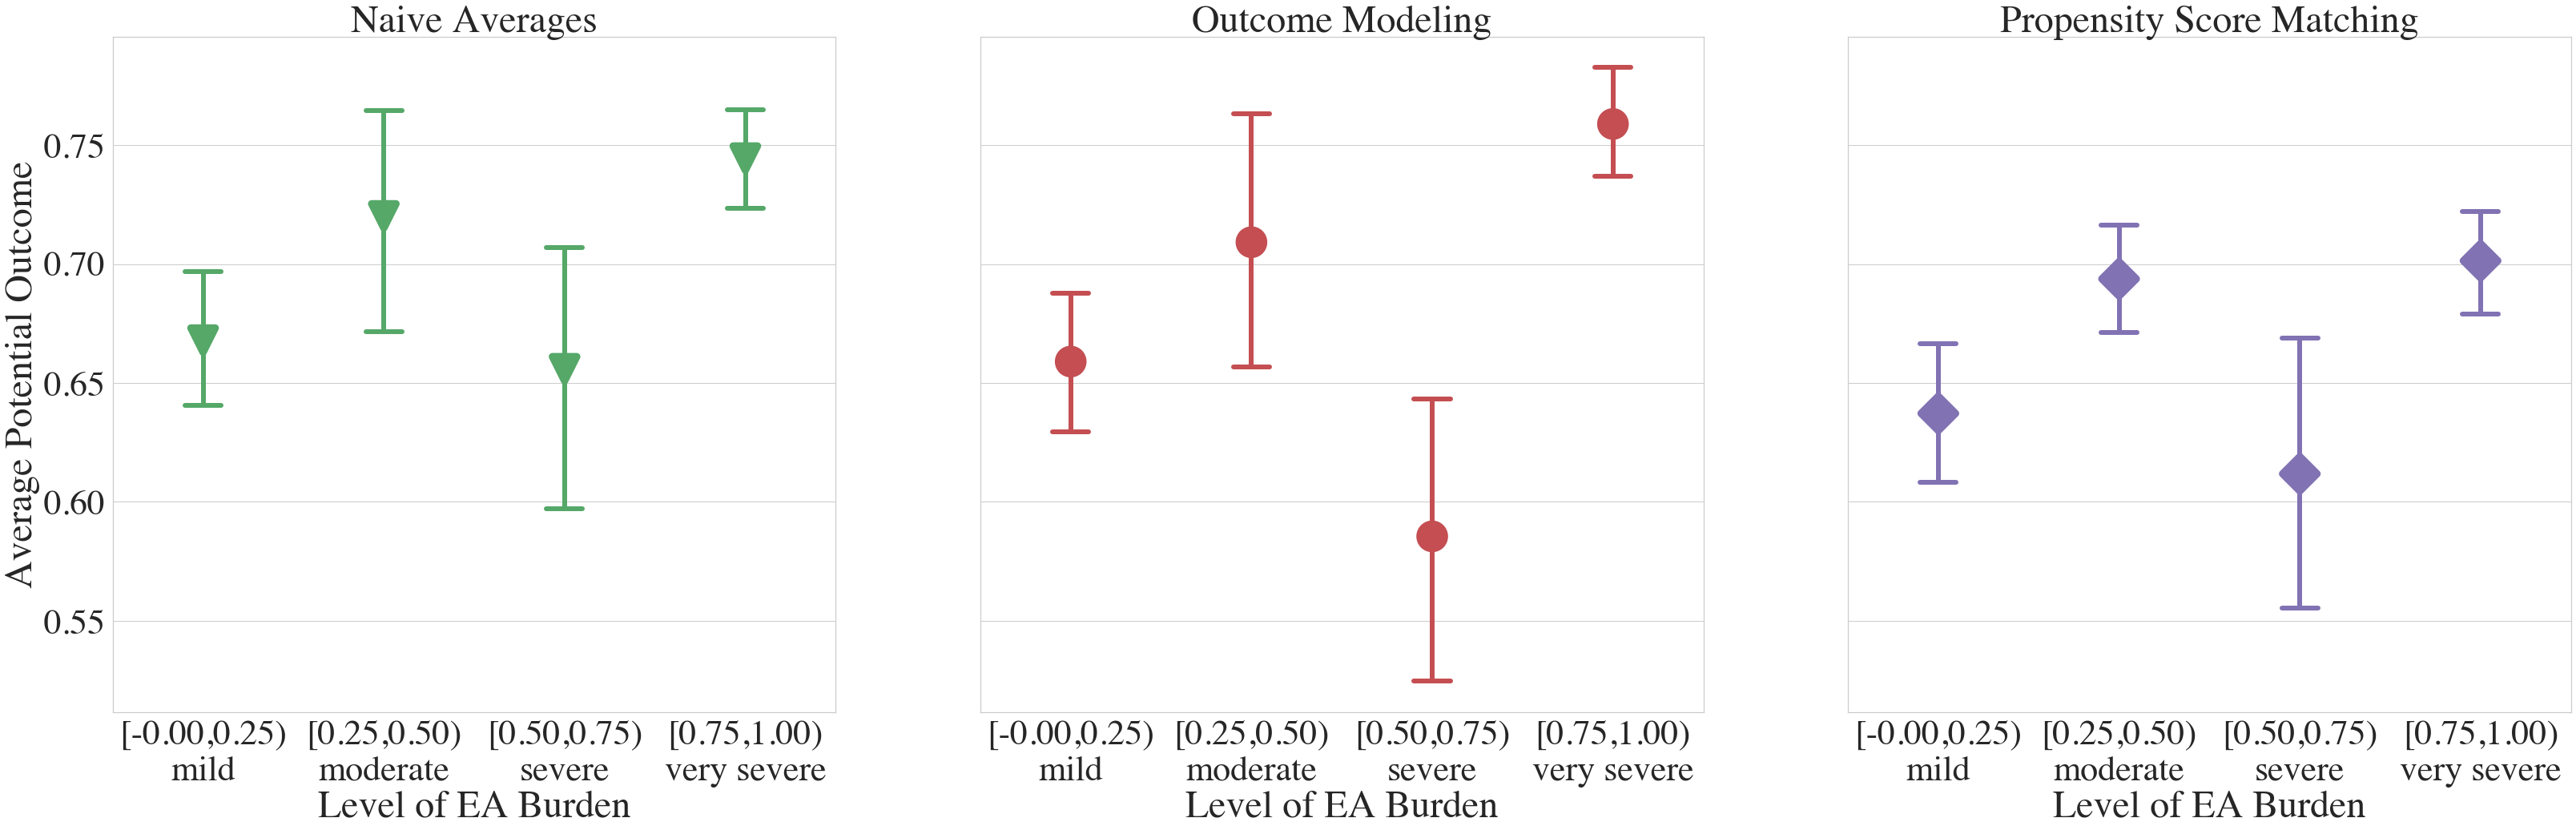

In [90]:
sns.set(font_scale=4,style='whitegrid')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)

fig,ax = plt.subplots(figsize=(55,15.5),ncols=3,sharey=True,sharex=True)
sns.pointplot(data=est_naive.reset_index(),
             x='index',y=0,ax=ax[0],join=False,
             capsize=.2,markers=['v'],dodge=0.25,scale = 4.5,errwidth=6,ci=90,color='C2')
sns.pointplot(data=est_lr.reset_index(),
             x='index',y=0,ax=ax[1],join=False,
             capsize=.2,markers=['o'],dodge=0.25,scale = 4.5,errwidth=6,ci=90,color='C3')
sns.pointplot(data=est_prop.reset_index().rename(columns={0:'Average Potential Outcome'}),
             x='iic',y='Average Potential Outcome',ax=ax[2],join=False,
             capsize=.2,markers=['D'],dodge=0.25,scale = 4.5,errwidth=6,ci=90,color='C4')
ax[0].set_ylabel('Average Potential Outcome')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_xlabel('Level of EA Burden')
ax[1].set_xlabel('Level of EA Burden')
ax[2].set_xlabel('Level of EA Burden')
ax[0].set_title('Naive Averages')
ax[1].set_title('Outcome Modeling')
ax[2].set_title('Propensity Score Matching')
level_eng = ['mild','moderate','severe','very severe']
plt.xticks(np.arange(len(thresholds)-1),['[%.2f,%.2f)\n%s'%(thresholds[i-1],thresholds[i],level_eng[i-1]) for i in range(1,len(thresholds)) ])
fig.savefig('max_reg.png')

In [88]:
 np.mean(lr_model.predict_proba(data_bootstrap.drop(columns=['Y']))[:,1])

0.8019095192714644

In [15]:
df_coarsen_2 = df_coarsen_1.copy(deep=True)
df_coarsen_2['levetiracetam'] = df_coarsen_2['levetiracetam'] > 20 
df_coarsen_2['propofol'] = df_coarsen_2['propofol'] > 1 
df_coarsen_2['midazolam'] = df_coarsen_2['midazolam'] > 0 
df_coarsen_2['lacosamide'] = df_coarsen_2['lacosamide'] > 0 
df_coarsen_2['phenobarbital'] = df_coarsen_2['phenobarbital'] > 0 
df_coarsen_2['valproate'] = df_coarsen_2['valproate'] > 0

df_coarsen_2[['levetiracetam','propofol','midazolam','lacosamide','phenobarbital','valproate','iic','Y']].groupby(by=['levetiracetam','propofol','midazolam','lacosamide','phenobarbital','valproate','iic']).count().rename({'0.12': '[0.0,0.25)', 
                                                                                                                        '0.38': '[0.25,0.50)', 
                                                                                                                        '0.62': '[0.50,0.75)', 
                                                                                                                        '0.88': '[0.75,1.00]'}, axis='index',level=6).to_csv('num_units_per_treatment_arm.csv')

In [39]:
df_coarsen_2[['levetiracetam','propofol','midazolam','lacosamide','phenobarbital','valproate','iic','Y']].std(axis=0)

levetiracetam    0.498508
propofol         0.496539
midazolam        0.299479
lacosamide       0.265742
phenobarbital    0.153501
valproate        0.198866
Y                0.403923
dtype: float64

In [43]:
df_coarsen_2[['levetiracetam','propofol','midazolam','lacosamide','phenobarbital','valproate','iic','Y']].corr().loc['Y'].abs()

levetiracetam    0.092473
propofol         0.158487
midazolam        0.077324
lacosamide       0.022664
phenobarbital    0.001288
valproate        0.032488
Y                1.000000
Name: Y, dtype: float64